<a href="https://colab.research.google.com/github/Lohitha-Vanteru/Bike-Share-Rebalancing-Project/blob/main/Bike_share_forecast_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### ***Importing Necessary Libraries*** :

In [1]:
#For Model interpretation
!pip install lime
!pip install shap

# Installing dtreeviz for visualizing decision tree
!pip install dtreeviz

#install xgboost
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np # mathematical computation
import pandas as pd # data processing
import matplotlib.pyplot as plt # visualization
from matplotlib import pyplot
import seaborn as sns # visualization
import warnings 
warnings.filterwarnings('ignore') #ignore warnings
from io import BytesIO
import datetime
import os

#set style
plt.style.use('seaborn')

# Setting font weight,label weight,title weight to bold and setting title size,label size,fontsize.
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["legend.title_fontsize"] = 15

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


#import for pickel file

import lime
from lime import lime_tabular
import shap

#### ***Importing Bike share rides data*** :

In [3]:

from google.colab import files
uploaded = files.upload()

Saving SeoulBikeData.csv to SeoulBikeData (2).csv


#### ***Reading CSV file into dataframe*** :


In [4]:
Bikes_df=pd.read_csv(BytesIO(uploaded['SeoulBikeData.csv']),encoding = 'unicode_escape')

#### ***Data Exploration And Data Cleaning*** :

In [5]:
# Check sample 5 rows
Bikes_df.sample(5)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
2015,22/02/2018,202,23,2.9,63,2.6,1253,-3.4,0.00,0.0,0.0,Winter,No Holiday,Yes
1002,11/01/2018,352,18,-10.4,43,2.3,1985,-20.6,0.02,0.0,0.0,Winter,No Holiday,Yes
5120,02/07/2018,104,8,20.8,96,0.4,1627,20.1,0.11,1.5,0.0,Summer,No Holiday,Yes
5426,15/07/2018,632,2,25.1,85,1.1,1379,22.3,0.00,0.0,0.0,Summer,No Holiday,Yes
4608,11/06/2018,918,0,20.3,58,1.4,2000,11.7,0.00,0.0,0.0,Summer,No Holiday,Yes


In [6]:
# overview of dimensions  and datatypes of the dataset 
print(f'The shape of dataset is {(Bikes_df.shape)} \n Total Rows are : {(Bikes_df.shape)[0]}\n Total Columns are : {(Bikes_df.shape)[1]}')
print('\n')
Bikes_df.info()

The shape of dataset is (8760, 14) 
 Total Rows are : 8760
 Total Columns are : 14


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday            

In [7]:
#Dealing with invalid data types
Bikes_df['Date']=Bikes_df['Date'].astype('datetime64[ns]')
Bikes_df['Seasons']=Bikes_df['Seasons'].astype('category')
Bikes_df['Holiday']=Bikes_df['Holiday'].astype('category')
Bikes_df['Hour']=Bikes_df['Hour'].astype('category')
Bikes_df['Functioning Day']=Bikes_df['Functioning Day'].astype('category')
# Renaming columns for better analysis
Bikes_df.rename(columns={'Rented Bike Count':'Rented_Bike_Count','Temperature(°C)':'Temperature','Humidity(%)':'Humidity','Wind speed (m/s)':'Wind_speed',
                       'Visibility (10m)':'Visibility','Dew point temperature(°C)':'Dew_point_temperature', 'Solar Radiation (MJ/m2)':'Solar_Radiation',
                        'Rainfall(mm)':'Rainfall','Snowfall (cm)':'Snowfall','Functioning Day':'Functioning_Day'},inplace=True)

#Extracting Month and Day of the week from Date
Bikes_df['Month']=Bikes_df['Date'].dt.month_name().astype('category')
Bikes_df['Day']=Bikes_df['Date'].dt.day_name().astype('category')
Bikes_df["year"] = Bikes_df['Date'].map(lambda x: x.year).astype("category")

#Adding Weekend column from day as 1 for weekedn and 0 for weekday
Bikes_df['Weekend']=Bikes_df['Day'].apply(lambda x: 1 if x=='Saturday' or x=='Sunday' else 0)
Bikes_df['Weekend']=Bikes_df['Weekend'].astype('category')
# drop the Date column
Bikes_df.drop(columns=['Date'],inplace=True)



In [8]:
# Checking for missing values
print(f'Null values :\n{Bikes_df.isnull().sum()}')
print('\n')
#Checking for duplicate values
print(f'Duplicate values : {sum(Bikes_df.duplicated())}')

Null values :
Rented_Bike_Count        0
Hour                     0
Temperature              0
Humidity                 0
Wind_speed               0
Visibility               0
Dew_point_temperature    0
Solar_Radiation          0
Rainfall                 0
Snowfall                 0
Seasons                  0
Holiday                  0
Functioning_Day          0
Month                    0
Day                      0
year                     0
Weekend                  0
dtype: int64


Duplicate values : 0


In [9]:
Bikes_df.describe().style.background_gradient()

,Rented_Bike_Count,Temperature,Humidity,Wind_speed,Visibility,Dew_point_temperature,Solar_Radiation,Rainfall,Snowfall
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


#### ***Exploratory Data Analysis :***

In [10]:
Bikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Rented_Bike_Count      8760 non-null   int64   
 1   Hour                   8760 non-null   category
 2   Temperature            8760 non-null   float64 
 3   Humidity               8760 non-null   int64   
 4   Wind_speed             8760 non-null   float64 
 5   Visibility             8760 non-null   int64   
 6   Dew_point_temperature  8760 non-null   float64 
 7   Solar_Radiation        8760 non-null   float64 
 8   Rainfall               8760 non-null   float64 
 9   Snowfall               8760 non-null   float64 
 10  Seasons                8760 non-null   category
 11  Holiday                8760 non-null   category
 12  Functioning_Day        8760 non-null   category
 13  Month                  8760 non-null   category
 14  Day                    8760 non-null   c

***When are the most rides happening ?*** 📅

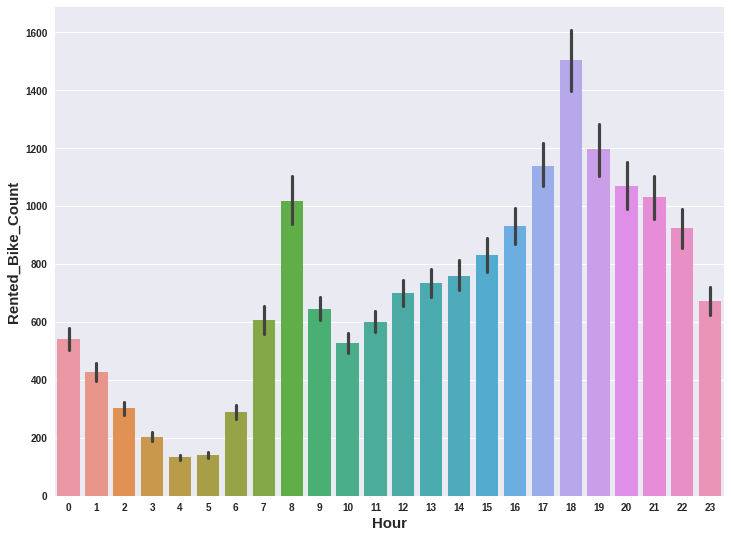

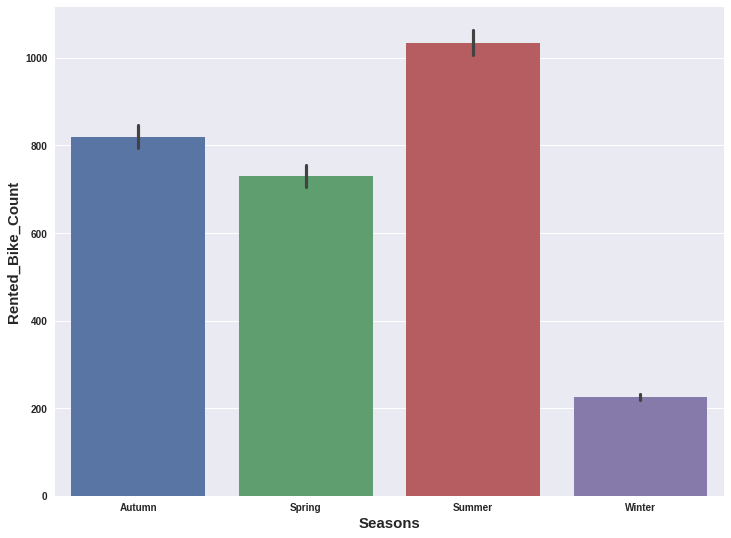

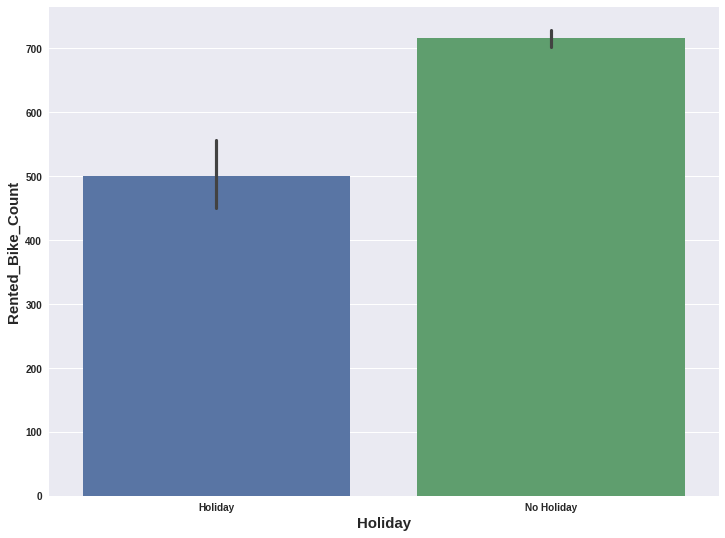

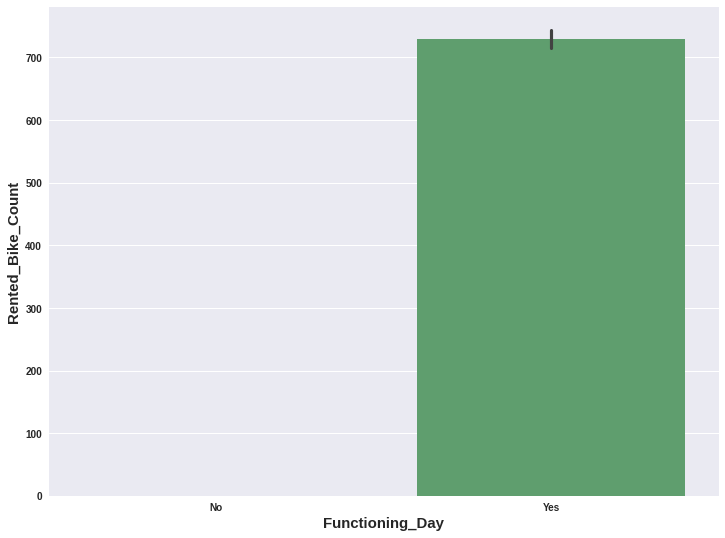

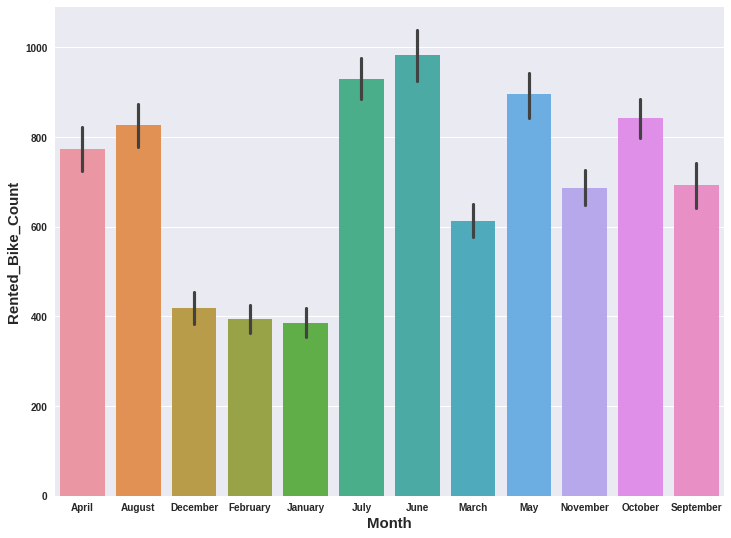

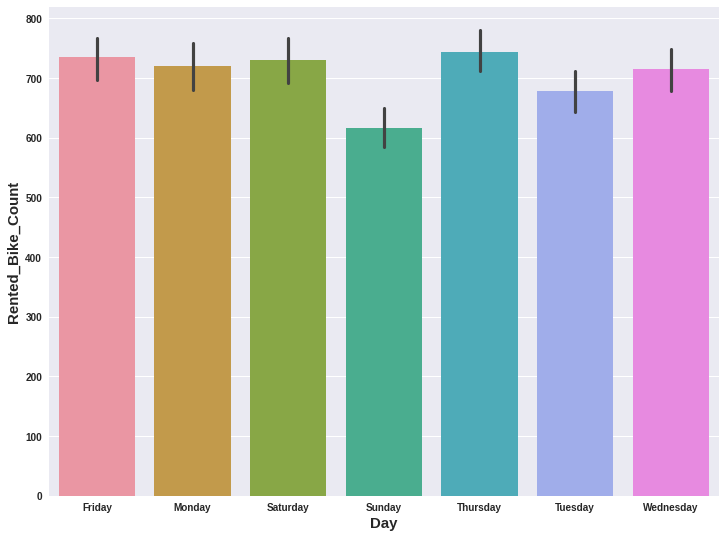

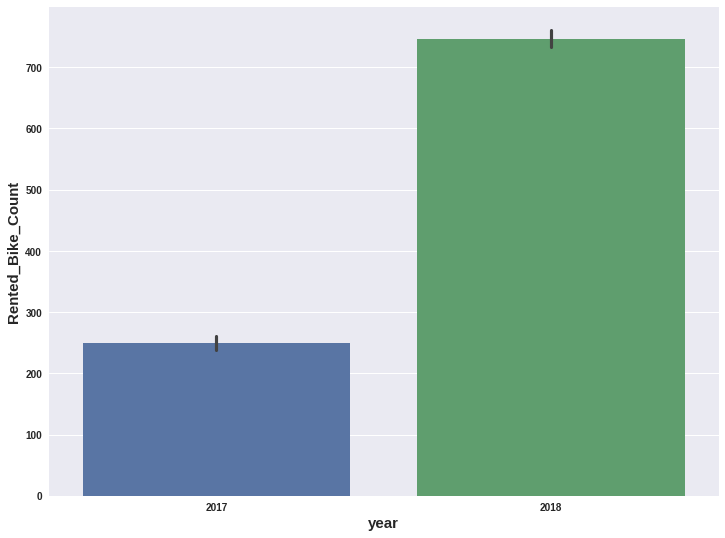

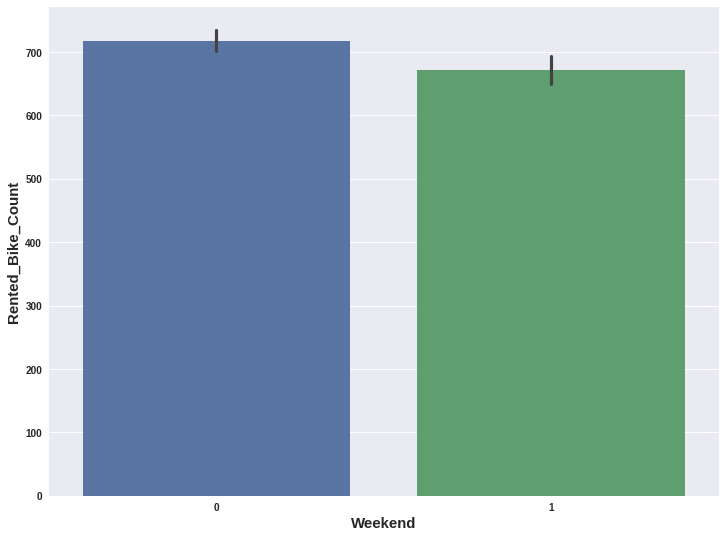

In [11]:
numeric_features= Bikes_df.select_dtypes(exclude=['category','datetime64'])
categorical_features=Bikes_df.select_dtypes(include='category')
# Plot barchart plot for each categorical columns with respect to target variable to get insights
for col in categorical_features:
    fig = plt.figure(figsize=(12, 9))
    ax = fig.gca()
    sns.barplot(x=Bikes_df[col],y=Bikes_df['Rented_Bike_Count'])



>***Observations:***

*  ***Time of day:*** It is evident that the peaks are observed in mornings at 8AM & 9AM and evenings at 4PM, 5PM & 6PM implicating that majority of the trips are taken before and after the usual office hours. Moreover, the trips taken in between the usual office hours i.e. 10AM — 3PM are constant. Additionaly, the trips have declined substantially after 6PM.

*   ***Day of week:*** As majority of the trips were taken before and after the usual office hours, it is no surprise that majority of the trips have taken place at weekdays (Mon-Fri) as compared to weekends (Sat-Sun)

*   ***Season :*** We observe that summer has the highest rentals followed by spring and then fall, which gives us reason to believe that the bike riders prefer warm to pleasant climates than colder climates.









##### ***What is the distribution of rides on different kinds of days wrt Hours?***

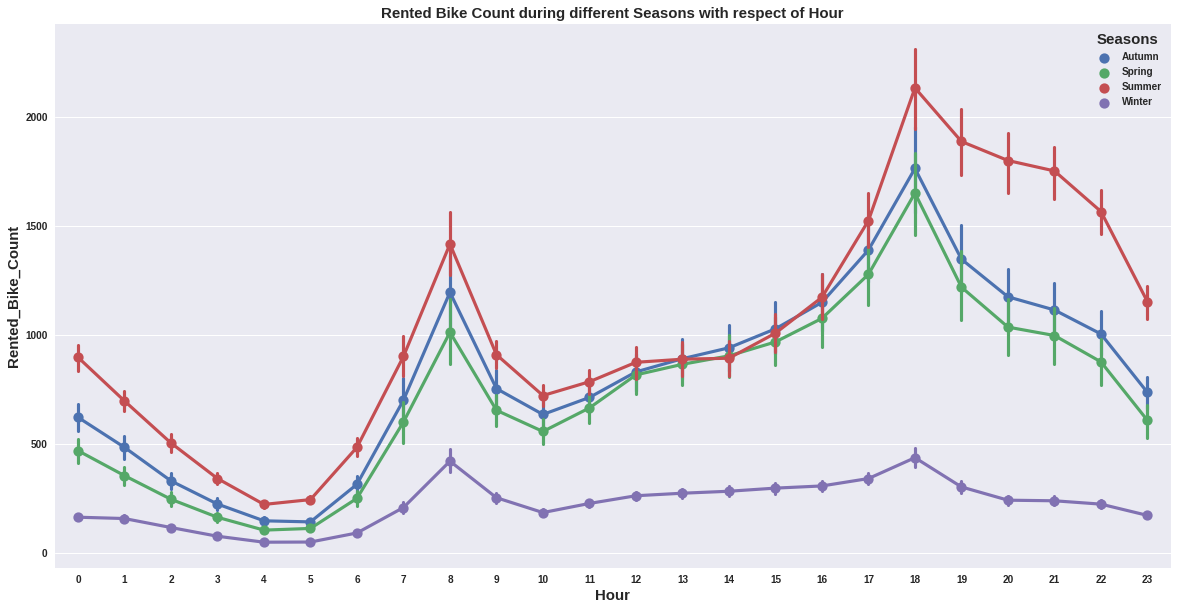

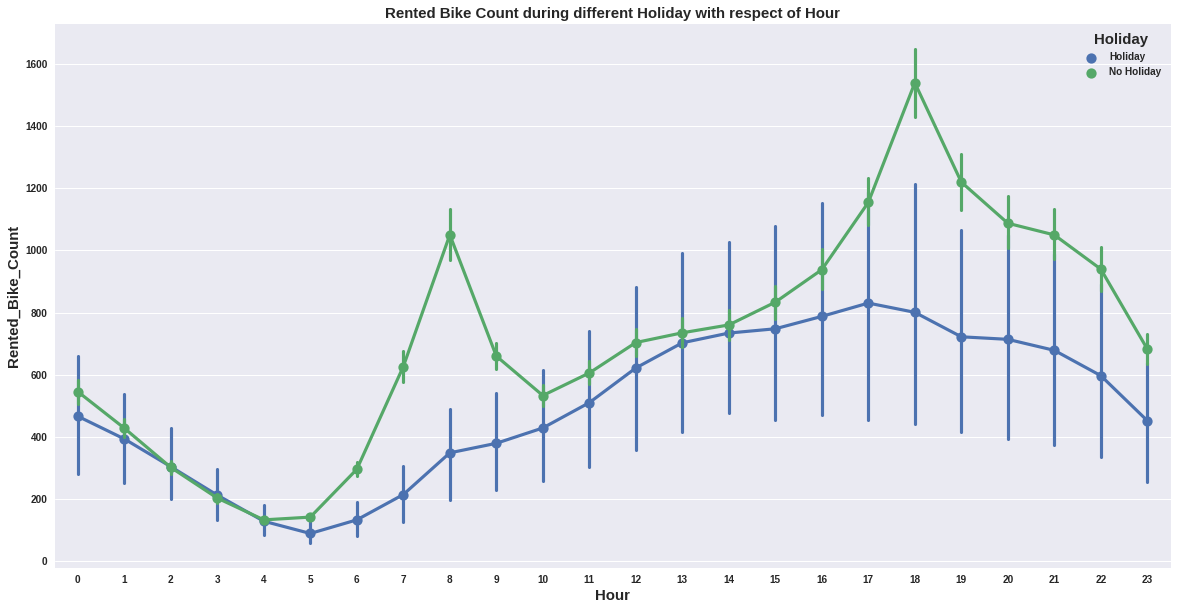

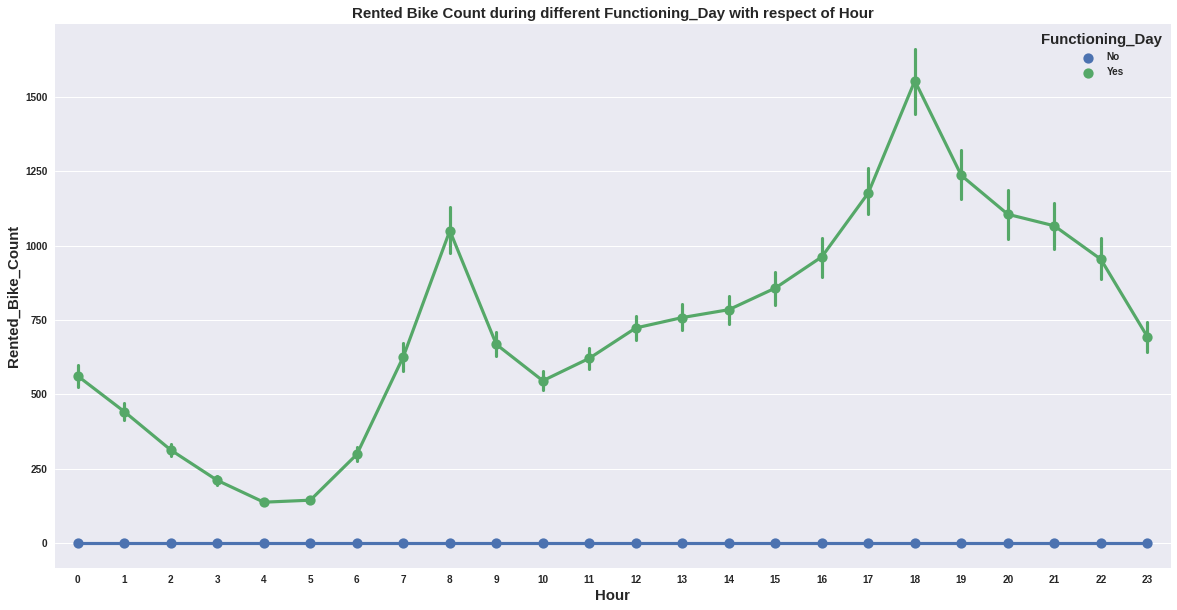

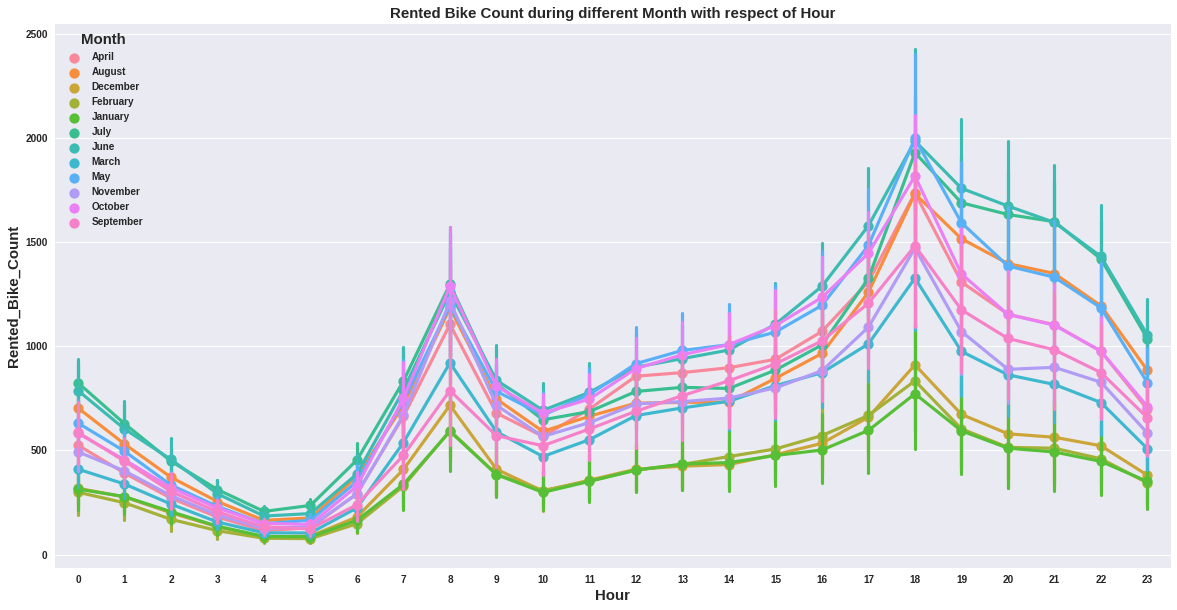

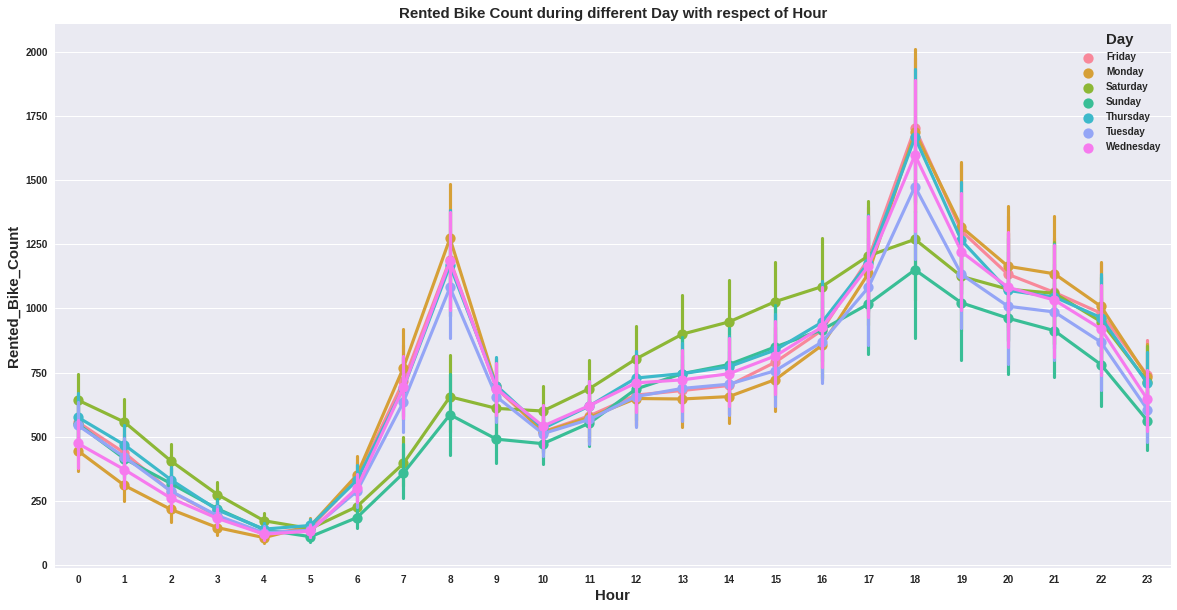

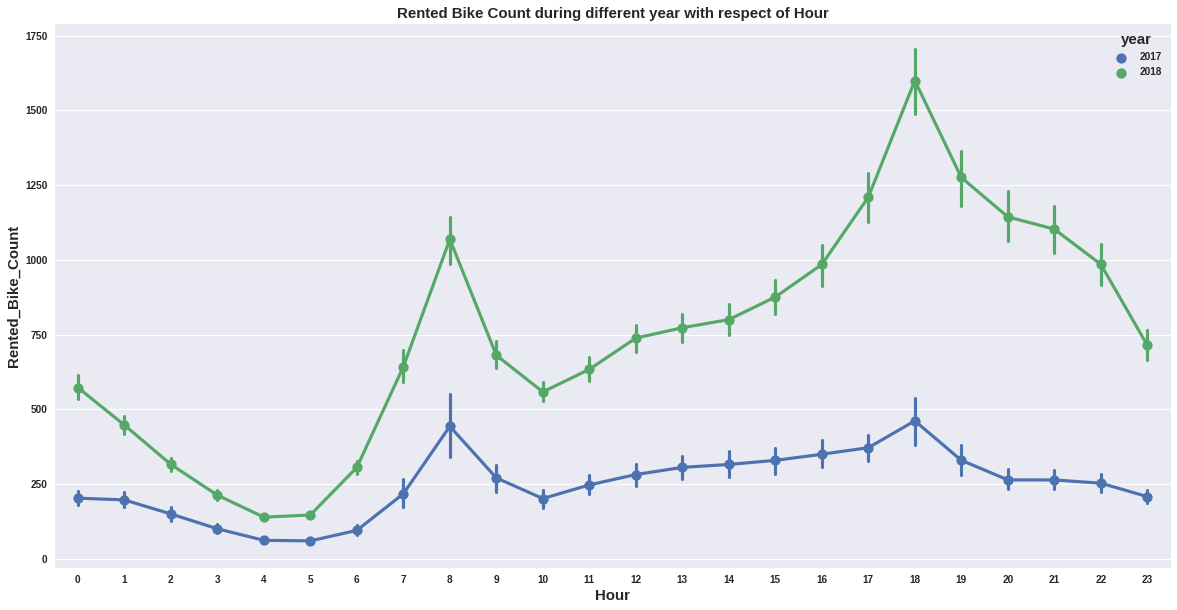

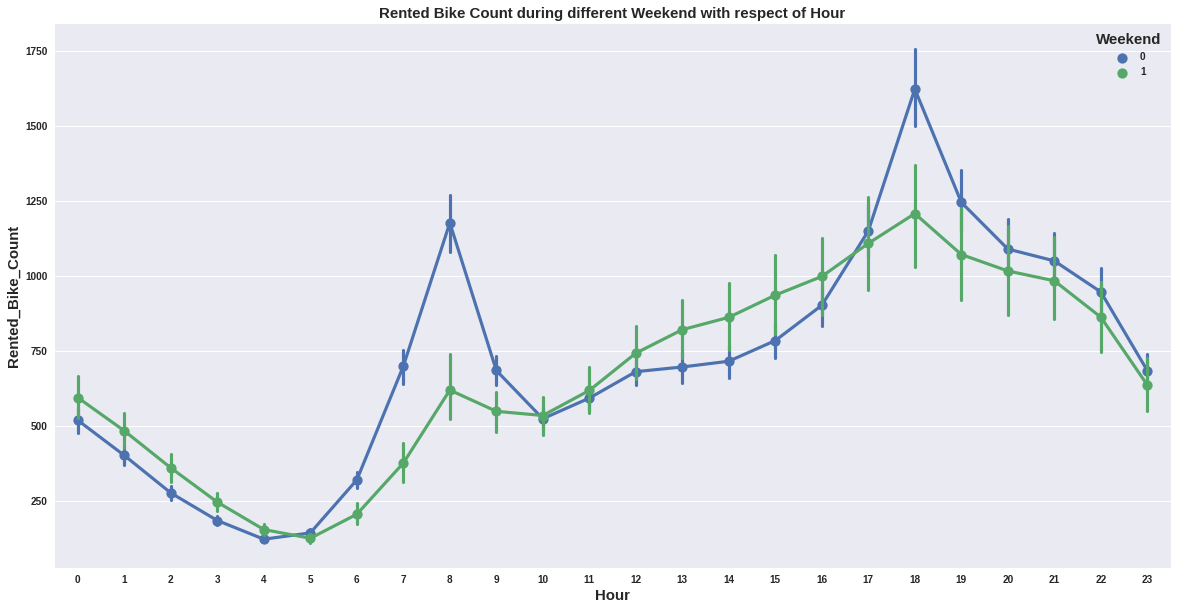

In [12]:
for i in categorical_features:
  if i == 'Hour':
    pass
  else:
    plt.figure(figsize=(20,10))
    sns.pointplot(x=Bikes_df["Hour"],y=Bikes_df['Rented_Bike_Count'],hue=Bikes_df[i])
    plt.title(f"Rented Bike Count during different {i} with respect of Hour")
  plt.show()



> ***Observations :***


* We can observe that the pattern of weekdays and weekends as well as Holidays is different, in the weekend and on holiday the demand becomes high in the afternoon. While the demand for office timings is high during weekdays and no holidays.

* In the month column, We can clearly see that the demand is low in December January & Febuary,  as it is cold in these months and we have already seen in season column that demand is less in winters.

*  Comparitively the demand was high in 2018 than in 2017, which can support the fact that bike share demand is increasing over the years.






#### ***What is the distribution and correlation among variables ?***



********************************************************************** Rented_Bike_Count **********************************************************************




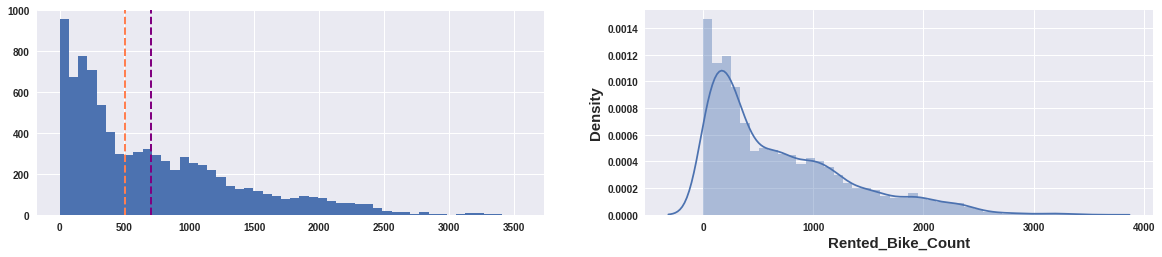



********************************************************************** Temperature **********************************************************************




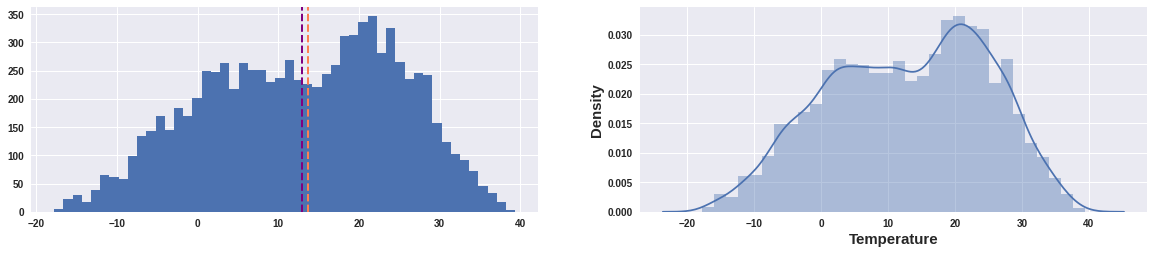



********************************************************************** Humidity **********************************************************************




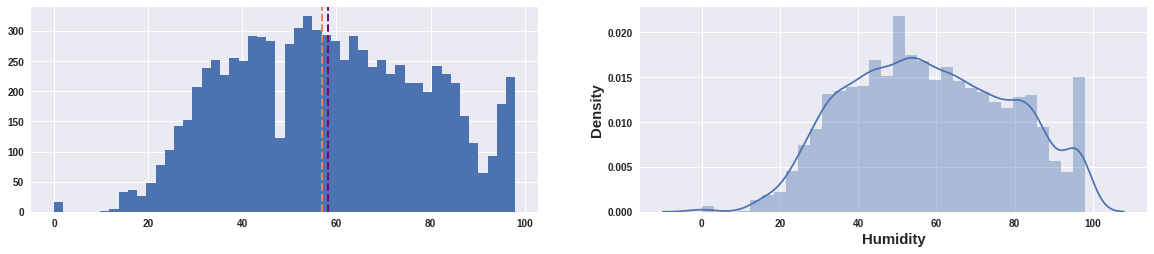



********************************************************************** Wind_speed **********************************************************************




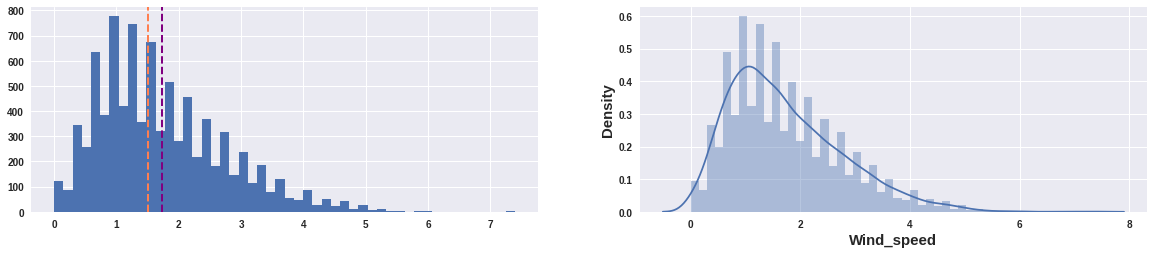



********************************************************************** Visibility **********************************************************************




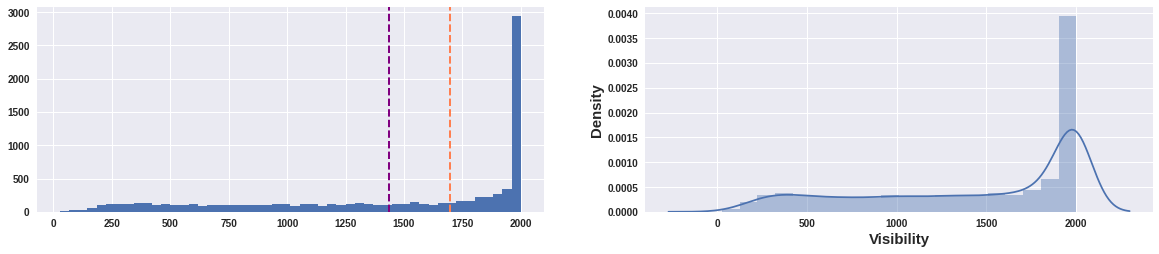



********************************************************************** Dew_point_temperature **********************************************************************




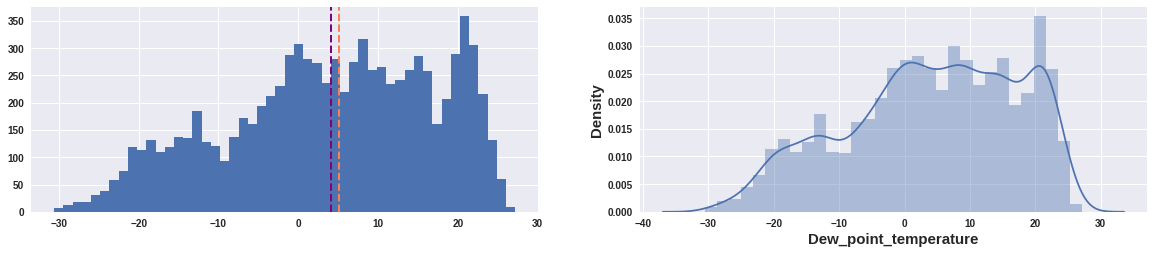



********************************************************************** Solar_Radiation **********************************************************************




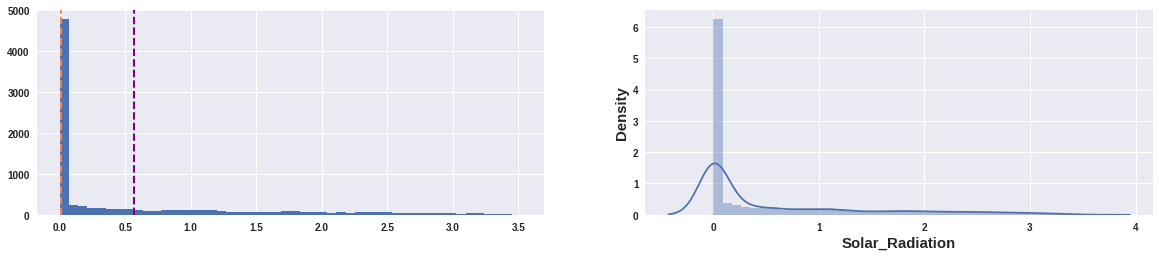



********************************************************************** Rainfall **********************************************************************




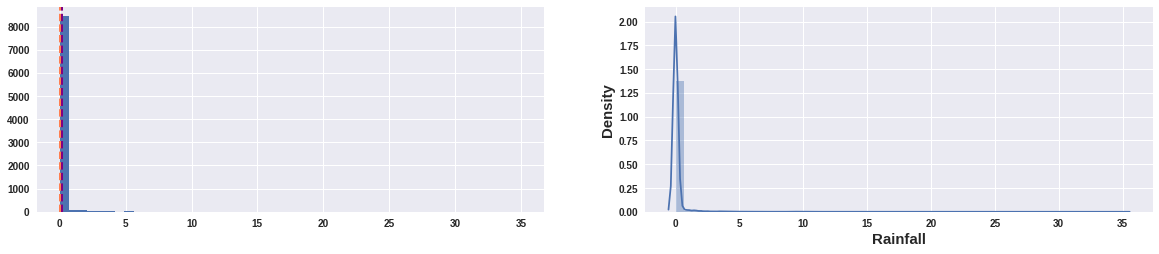



********************************************************************** Snowfall **********************************************************************




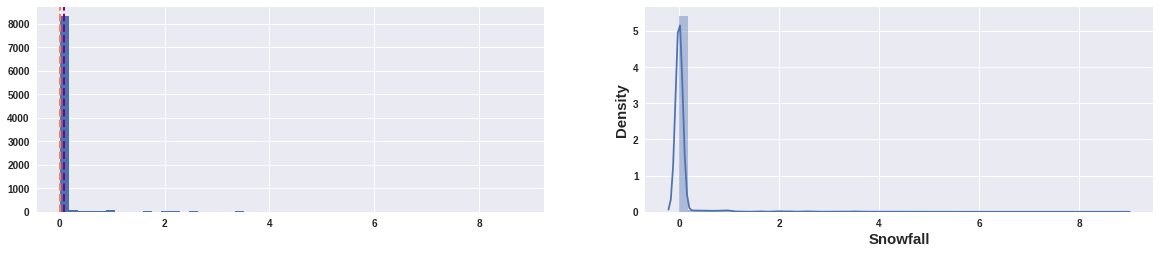

In [13]:
#plotting histogram with mean and median, and distplot of all the numeric features of the dataset
n=1
for i in numeric_features.columns:
  plt.figure(figsize=(20,40))
  plt.subplot(9,2,n)
  n+=1
  print('\n')
  print('*'*70,i,'*'*70)
  print('\n')
  # fig=plt.figure()
  # ax=fig.gca()
  feature=Bikes_df[i]
  feature.hist(bins=50,)
  plt.axvline(feature.mean(), color='purple', linestyle='dashed', linewidth=2)
  plt.axvline(feature.median(), color='coral', linestyle='dashed', linewidth=2) 
  plt.subplot(9,2,n)
  n+= 1
  sns.distplot(Bikes_df[i])
  # plt.tight_layout()
  plt.show()

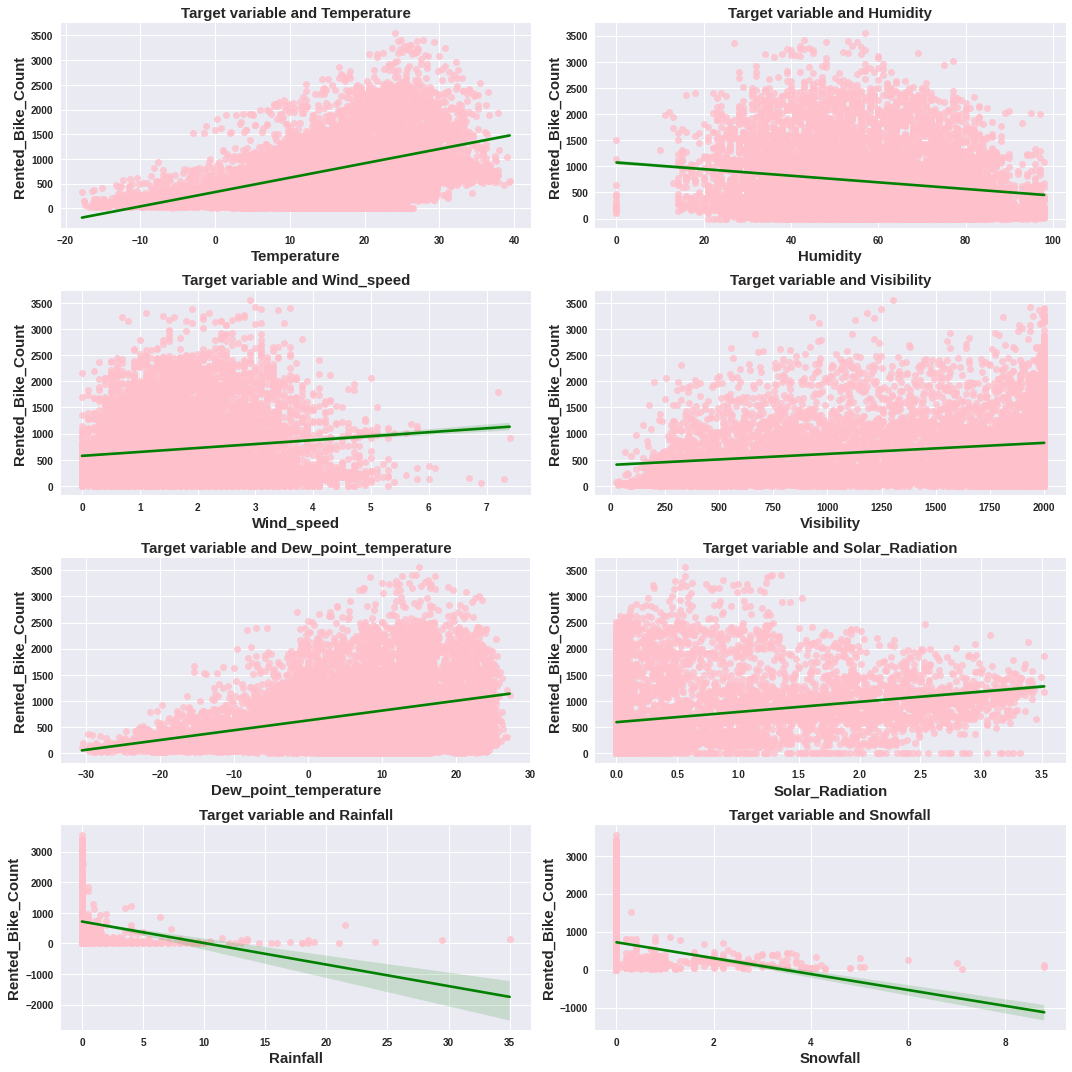

In [14]:
# Regression plot to know relation of target variable with our independent variable
n=1
plt.figure(figsize=(15,15))
for i in numeric_features.columns:
  if i == 'Rented_Bike_Count':
    pass
  else:
    plt.subplot(4,2,n)
    n+=1
    sns.regplot(Bikes_df[i], Bikes_df['Rented_Bike_Count'],scatter_kws={"color": "pink"}, line_kws={"color": "green"})
    plt.title(f'Target variable and {i}')
    plt.tight_layout()

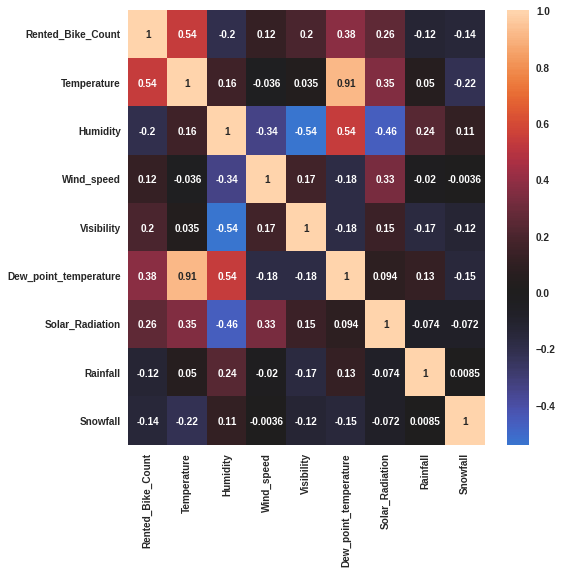

In [15]:
#correlation of all the numerical features with the heat map, so that we will also get to know the multicolinearity
plt.figure(figsize=(8,8))
sns.heatmap(Bikes_df.select_dtypes(include=['float','int']).corr(),annot=True,center = 0)
plt.show()

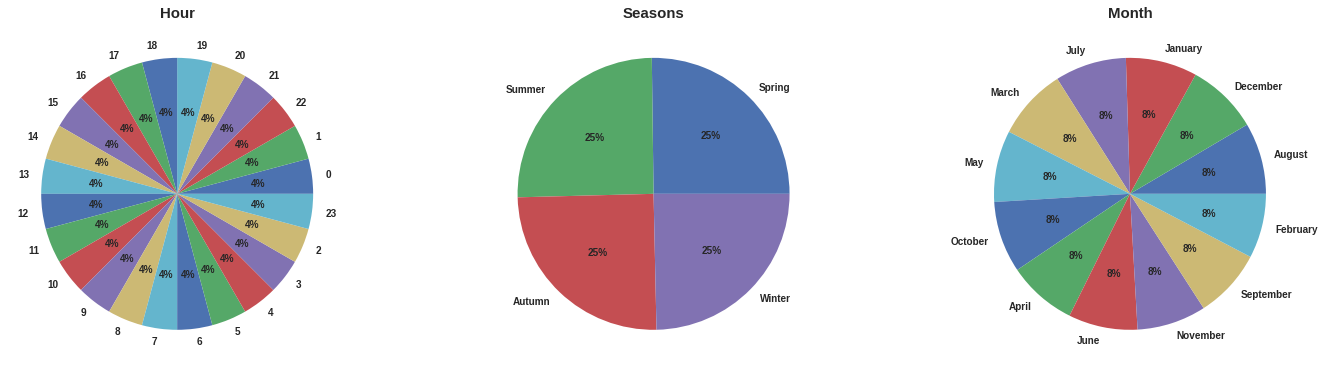

In [16]:
#Checking for Data imbalance by creating pieplot
n=1
plt.figure(figsize=(20,15))
columns=['Hour','Seasons','Month']
for i in columns:
  plt.subplot(3,3,n)
  n=n+1
  plt.pie(Bikes_df[i].value_counts(),labels = Bikes_df[i].value_counts().keys().tolist(),autopct='%.0f%%')
  plt.title(i)
  plt.tight_layout()



>***Observations :***


*   From the distplots we could see that some of the variables are either right or lwft skewed and for those variables, even the mean and median are skewed as seen in the histograms.

*  Regression plots show that the few variables are positively correlated and few are nagtively correlated with our target variable.

* From Heat map, we could see that there is multicollineriaty between few variables like Temperature and Dew point temperature.

* From the pie plots , we could see that the data is uniformly distributed across all seasons, months and hours. Hence, there is no data imbalance.





#### ***Preparing Data for Modeling*** :

In [17]:
# Make copy of dataset
df=Bikes_df.copy()
df

,Rented_Bike_Count,Hour,Temperature,Humidity,Wind_speed,Visibility,Dew_point_temperature,Solar_Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning_Day,Month,Day,year,Weekend
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,January,Thursday,2017,0
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,January,Thursday,2017,0
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,January,Thursday,2017,0
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,January,Thursday,2017,0
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,January,Thursday,2017,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes,November,Friday,2018,0
8756,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes,November,Friday,2018,0
8757,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes,November,Friday,2018,0
8758,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes,November,Friday,2018,0


***Multicollinearity*** can be a problem in a regression model because we would not be able to distinguish between the individual effects of the independent variables on the dependent variable.It can be detected via various methods. 
In this project, we used the most common approach ***VIF (Variable Inflation Factors).***

VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable.If VIF >5, then variables are highly collinear and the parameter estimates will have large stanhdard errors due to this.








In [18]:
#Detecting Multicollinearity using VIF(Variable Inflation Factors)
def Calculate_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)
#excluding target variable
Calculate_vif(df[[i for i in df.describe().columns if i not in ['Rented_Bike_Count']]])

,variables,VIF
0,Temperature,29.075866
1,Humidity,5.069743
2,Wind_speed,4.517664
3,Visibility,9.051931
4,Dew_point_temperature,15.201989
5,Solar_Radiation,2.821604
6,Rainfall,1.079919
7,Snowfall,1.118903


In [19]:
# As per above vif calculation dropping  dew_point_temperature columns.
df.drop(['Dew_point_temperature','Day'],inplace=True,axis=1)
Calculate_vif(df[[i for i in df.describe().columns if i not in ['Rented_Bike_Count']]])

,variables,VIF
0,Temperature,3.166007
1,Humidity,4.758651
2,Wind_speed,4.079926
3,Visibility,4.409448
4,Solar_Radiation,2.246238
5,Rainfall,1.078501
6,Snowfall,1.118901


In [20]:
# Creating dummy variables
df=pd.get_dummies(df,drop_first=True,sparse=True)
# checking modified data
df.head(5)

,Rented_Bike_Count,Temperature,Humidity,Wind_speed,Visibility,Solar_Radiation,Rainfall,Snowfall,Hour_1,Hour_2,...,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,year_2018,Weekend_1
0,254,-5.2,37,2.2,2000,0.0,0.0,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,204,-5.5,38,0.8,2000,0.0,0.0,0.0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,173,-6.0,39,1.0,2000,0.0,0.0,0.0,0,1,...,1,0,0,0,0,0,0,0,0,0
3,107,-6.2,40,0.9,2000,0.0,0.0,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,78,-6.0,36,2.3,2000,0.0,0.0,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0


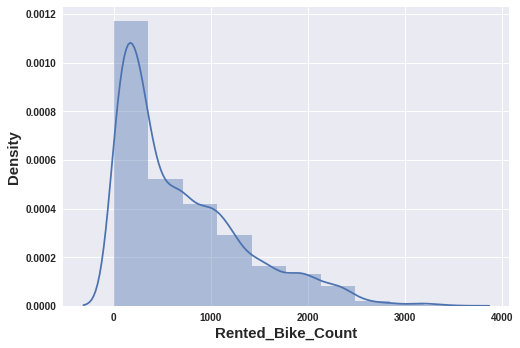

In [21]:
# Plot the distribution of the target variable to check for skewness
fig = plt.figure()
sns.distplot((df['Rented_Bike_Count']), bins = 10)


As the target variable is right skewed, we can normalize it by applying  either squareroot or log transformation.

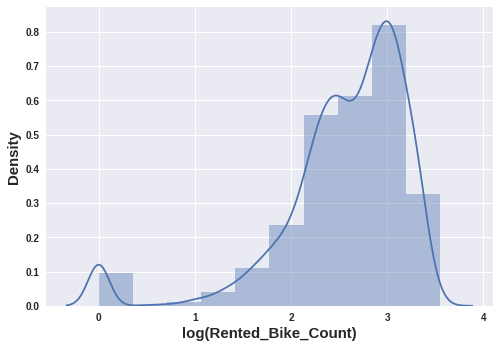

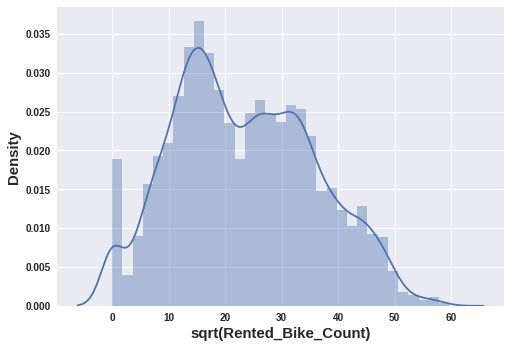

In [22]:
# log tranformation (adding 1 to bike count to avoid log(0) error)
df['log(Rented_Bike_Count)'] = np.log10(df['Rented_Bike_Count']+1)
fig = plt.figure()
sns.distplot(df['log(Rented_Bike_Count)'], bins = 10)

#square_root transformation
df['sqrt(Rented_Bike_Count)'] = np.sqrt(df['Rented_Bike_Count'])
fig = plt.figure()
sns.distplot(df['sqrt(Rented_Bike_Count)'])

In [23]:
print(f"Skewness of Target Variable : {df['Rented_Bike_Count'].skew():.2f}")
#print(f"Skewness of Logarithm of Target Variable : {df['log(Rented_Bike_Count)'].skew():.2f}")
print(f"Skewness of Square root of Target Variable : {df['sqrt(Rented_Bike_Count)'].skew():.2f}")

Skewness of Target Variable : 1.15
Skewness of Square root of Target Variable : 0.24


Here, we could see that the target variable is balanced better, after applying square root transformation and the skewness is greatly reduced.

In [24]:
df.drop(['log(Rented_Bike_Count)','sqrt(Rented_Bike_Count)'],axis=1,inplace=True)

#### ***Defining Function to train the models :***

In [25]:
# creating a list so that all models evalution scores will be appended to the corrosponding list after hyperarameter
mean_absolute_error_tuned = []
mean_sq_error_tuned=[]
root_mean_sq_error_tuned=[]
accuracy_score_tuned =[]
r2_list_tuned=[]
adjusted_r2_list_tuned=[]

# creating a function for fit, predict and evaluting the models and append all evalution score in list 
def model_train(model,X_train,X_test,Y_train,Y_test, linear = False):
  '''
    train the model and gives mae, mse,rmse,r2 and adjusted r2 scores of the model 
  '''
  #training the model
  model.fit(X_train,Y_train)
  # Accuracy Score
  accuracy  = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5).mean()
  print('*'*30, 'Cross validation Accuracy score', '*'*30)
  print("Accuracy score  :", accuracy)

  print('\n')

  try:
      # finding the best parameters of the model if any 
    print('*'*20, 'Best Parameters & Best Score', '*'*20)
    print(f"The best parameter that was found out is :{model.best_params_} \nwhere model's best score is:  {model.best_score_} \n")
  except:
    print('None')
    
    

  #predicting the Test set and evaluting the models 
  print('\n')
  print('*'*20, 'Evalution Metrics', '*'*20)

  if linear == True:
    Y_pred = model.predict(X_test)
    #squaring the target variable test and prediction values as we took y as square root of target variable in modeling.
    #finding mean_absolute_error
    MAE  = mean_absolute_error(Y_test**2,Y_pred**2)
    print("MAE :" , MAE)

    #finding mean_squared_error
    MSE  = mean_squared_error(Y_test**2,Y_pred**2)
    print("MSE :" , MSE)

    #finding root mean squared error
    RMSE = np.sqrt(MSE)
    print("RMSE :" ,RMSE)

    #finding the r2 score
    '''
    R2 assumes that every single variable explains the variation in the dependent variable
    '''
    r2 = r2_score(Y_test**2,Y_pred**2)
    print("R2 :" ,r2)

    #finding the adjusted r2 score
    '''
    The adjusted R2 gives the percentage of variation explained by 
    only the independent variables that actually affect the dependent variable.
    '''
    adj_r2=1-(1-r2_score(Y_test**2,Y_pred**2))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
    print("Adjusted R2 : ",adj_r2,'\n')
  
  else:
    # for tree base models
    Y_pred = model.predict(X_test)

    #finding mean_absolute_error
    MAE  = mean_absolute_error(Y_test,Y_pred)
    print("MAE :" , MAE)

    #finding mean_squared_error
    MSE  = mean_squared_error(Y_test,Y_pred)
    print("MSE :" , MSE)

    #finding root mean squared error
    RMSE = np.sqrt(MSE)
    print("RMSE :" ,RMSE)

    #finding the r2 score
    
    r2 = r2_score(Y_test,Y_pred)
    print("R2 :" ,r2)
    #finding the adjusted r2 score
    adj_r2=1-(1-r2_score(Y_test,Y_pred))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
    print("Adjusted R2 : ",adj_r2,'\n')

    #Top 10 feature importance graph
    try:
      best = model.best_estimator_
      features = new_X.columns
      importances = best.feature_importances_[0:10]
      indices = np.argsort(importances)
      plt.figure(figsize=(10,15))
      plt.title('Feature Importance')
      plt.barh(range(len(indices)), importances[indices], color='blue',edgecolor='pink' ,align='center')
      plt.yticks(range(len(indices)), [features[i] for i in indices])
      plt.xlabel('Relative Importance')
      plt.show()
    
    except:
      pass
  
  # Here we appending the parameters for all models 
  mean_absolute_error_tuned.append(MAE)
  mean_sq_error_tuned.append(MSE)
  root_mean_sq_error_tuned.append(RMSE)
  accuracy_score_tuned.append(accuracy)
  r2_list_tuned.append(r2)
  adjusted_r2_list_tuned.append(adj_r2)

  # print the coefficient and intercept for linear models
  if model == LR:
    print("*"*25, "coefficient", "*"*25)
    print(pd.DataFrame(model.coef_,X.columns, columns=['Coefficient']))
    print('\n')
    print("*"*25, "Intercept", "*"*25)
    print('\n')
    print(model.intercept_)
  else:
    pass
  print('\n')
  
  print('*'*20, 'ploting the graph of actual and predicted only with 100 observation', '*'*20)

  # ploting the graph of Actual and predicted only with 100 observation for better visualisation which model have these parameters and else we just pass them
  try:
    # ploting the line graph of actual and predicted values  
    plt.figure(figsize=(15,7))
    plt.plot((Y_pred)[:100])
    plt.plot((np.array(Y_test)[:100]))
    plt.legend(["Predicted","Actual"])
    plt.show()
  except:
    pass

#### ***Linear models without hyperparameter tuning:***

In [26]:
mean_abs_error = []
mean_sq_error=[]
root_mean_sq_error=[]
accuracy_score =[]
r2_list=[]
adj_r2_list=[]

# Define X-variable(Independent Variables) and Y-Variable(Dependent Variable)
X=df.drop('Rented_Bike_Count',axis=1)
y=np.sqrt(df['Rented_Bike_Count'])
#X=df.iloc[:,1:]
#y=df.iloc[:,1]
#y=df['Rented_Bike_Count']
# Split data into train test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
#scaling the features
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
# Checking shape
print(f'Shape of X_train : {X_train.shape}')
print(f'Shape of y_train : {y_train.shape}')
print(f'Shape of X_test : {X_test.shape}')
print(f'Shape of y_test : {y_test.shape}')

#instantiating the model
lr = LinearRegression()
l1 = Lasso()
l2 = Ridge()
e  = ElasticNet()

linear_models = [lr,l1,l2,e]
for i in linear_models:
  print('\n')
  print('*'*20,i,'*'*20) 
  i.fit(X_train,y_train)
  y_pred = i.predict(X_test)
  mae = mean_absolute_error(y_test**2,y_pred**2)
  print("MAE :" , mae)
  mse = mean_squared_error(y_test**2,y_pred**2)
  print("MSE :" , mse)
  rmse = np.sqrt(mse)
  print("RMSE :" , rmse)
  r2 = r2_score(y_test**2,y_pred**2)
  print("R2 :" , r2)
  adj_r2 =1-(1-r2)*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
  print("Adjusted_R2 :" , adj_r2)
  accuracy=i.score(X_train,y_train)
  print("Cross validation accuracy:" , accuracy)


  accuracy_score.append(accuracy)
  mean_abs_error.append(mae)
  mean_sq_error.append(mse)
  root_mean_sq_error.append(rmse)
  r2_list.append(r2)
  adj_r2_list.append(adj_r2)


Shape of X_train : (6570, 48)
Shape of y_train : (6570,)
Shape of X_test : (2190, 48)
Shape of y_test : (2190,)


******************** LinearRegression() ********************
MAE : 227.50969877638366
MSE : 112620.2639493482
RMSE : 335.5894276483516
R2 : 0.7299984831548496
Adjusted_R2 : 0.7239452030013853
Cross validation accuracy: 0.7570981422352079


******************** Lasso() ********************
MAE : 301.94508872426184
MSE : 201298.35827721123
RMSE : 448.66285591433933
R2 : 0.5173971346956685
Adjusted_R2 : 0.506577453455777
Cross validation accuracy: 0.6248259431846451


******************** Ridge() ********************
MAE : 227.51906606188348
MSE : 112630.60250460054
RMSE : 335.6048308719655
R2 : 0.7299736969795894
Adjusted_R2 : 0.7239198611341995
Cross validation accuracy: 0.7570981019582648


******************** ElasticNet() ********************
MAE : 304.53928805503125
MSE : 202031.1619236513
RMSE : 449.4787669330458
R2 : 0.5156402741703063
Adjusted_R2 : 0.504781205118543
C

#### ***Linear Models with Hyperparameter tuning :***

######**Linear Regression**

****************************** Cross validation Accuracy score ******************************
Accuracy score  : 0.7515570009169255


******************** Best Parameters & Best Score ********************
None


******************** Evalution Metrics ********************
MAE : 227.50969877638366
MSE : 112620.2639493482
RMSE : 335.5894276483516
R2 : 0.7299984831548496
Adjusted R2 :  0.7239452030013853 

************************* coefficient *************************
                     Coefficient
Temperature             5.592139
Humidity               -2.845056
Wind_speed             -0.143280
Visibility              0.338213
Solar_Radiation         0.991277
Rainfall               -1.705572
Snowfall               -0.014262
Hour_1                 -0.397186
Hour_2                 -1.022456
Hour_3                 -1.463667
Hour_4                 -1.878291
Hour_5                 -1.770962
Hour_6                 -0.833589
Hour_7                  0.429649
Hour_8                  1.448099
Hou

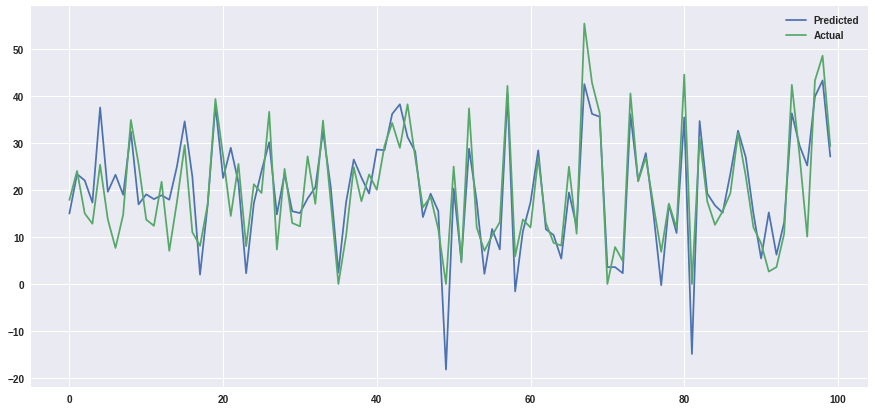

In [27]:
LR= LinearRegression()
model_train(LR,X_train,X_test,y_train,y_test,linear=True)

######**Lasso Regression**

****************************** Cross validation Accuracy score ******************************
Accuracy score  : 0.7516265369415902


******************** Best Parameters & Best Score ********************
The best parameter that was found out is :{'alpha': 0.01} 
where model's best score is:  0.7516265369415902 



******************** Evalution Metrics ********************
MAE : 227.85897282279106
MSE : 112990.13405013754
RMSE : 336.14005124373017
R2 : 0.7291117378681071
Adjusted R2 :  0.7230385773906056 



******************** ploting the graph of actual and predicted only with 100 observation ********************


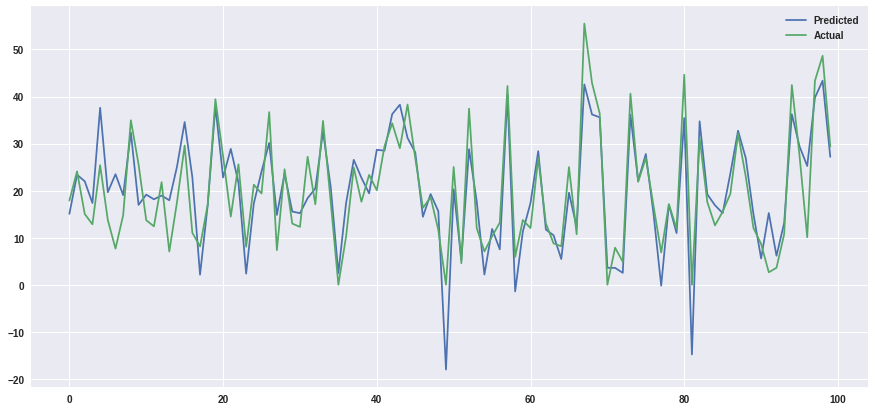

In [28]:
# Using Grid Search CV for Hyperparameter tuning of Lasso Regression model
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100,0.0014]} #lasso parameters 
L1 = GridSearchCV(Lasso(), parameters, cv=5) #using gridsearchcv and cross validation on the model
# fit and evaluate model 
model_train(L1,X_train,X_test,y_train,y_test,linear=True)

######**Ridge Regression**

****************************** Cross validation Accuracy score ******************************
Accuracy score  : 0.7515725380130938


******************** Best Parameters & Best Score ********************
The best parameter that was found out is :{'alpha': 20} 
where model's best score is:  0.7515725380130938 



******************** Evalution Metrics ********************
MAE : 227.71242542250445
MSE : 112834.66525360545
RMSE : 335.9087156559136
R2 : 0.7294844666241385
Adjusted R2 :  0.7234196625129561 



******************** ploting the graph of actual and predicted only with 100 observation ********************


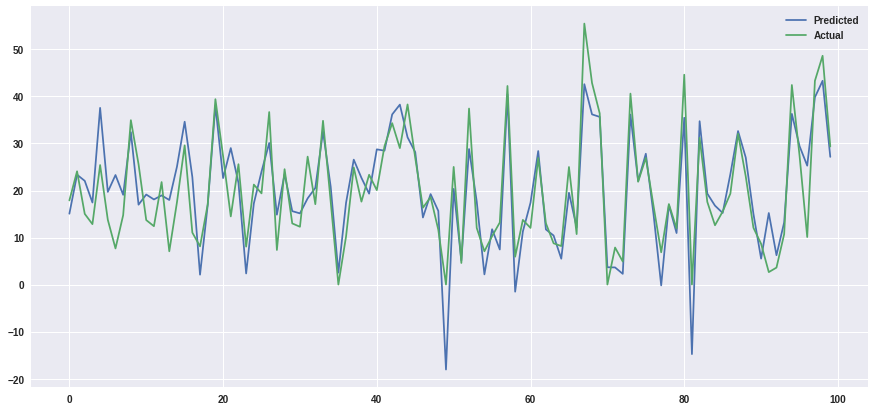

In [29]:
# Using Grid Search CV for Hyperparameter tuning for Lasso Regression
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45,50,55,60,100,0.5,1.5,1.6,1.7,1.8,1.9]} # giving parameters 
L2 = GridSearchCV(Ridge(), parameters, scoring='r2', cv=5) #using gridsearchcv and cross validate the model
# fit and evaluate model with score_matrix function
model_train(L2,X_train,X_test,y_train,y_test,linear=True)

######**Elastic Regression**

****************************** Cross validation Accuracy score ******************************
Accuracy score  : 0.7515903825105702


******************** Best Parameters & Best Score ********************
The best parameter that was found out is :{'alpha': 0.01} 
where model's best score is:  0.7515903825105702 



******************** Evalution Metrics ********************
MAE : 228.03775846282394
MSE : 113173.17764350834
RMSE : 336.41221387385497
R2 : 0.72867289989947
Adjusted R2 :  0.7225899009247734 



******************** ploting the graph of actual and predicted only with 100 observation ********************


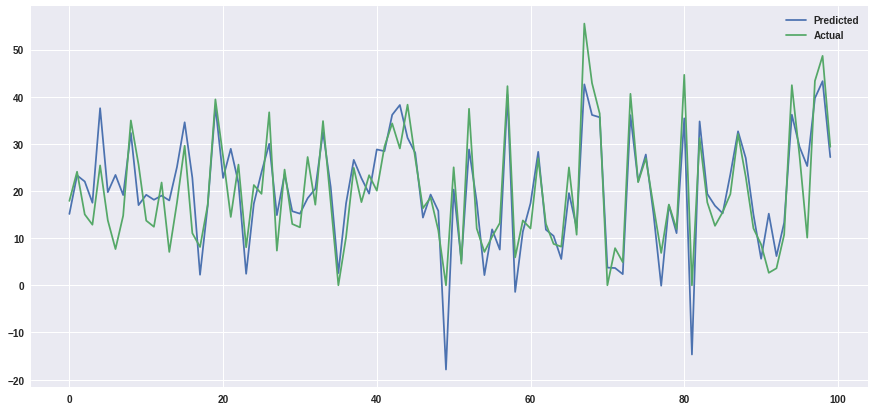

In [30]:
# Using Grid Search CV for Hyperparameter tuning for Lasso Regression
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45,50,55,60,100,0.5,1.5,1.6,1.7,1.8,1.9]} # giving parameters 
E = GridSearchCV(ElasticNet(), parameters, scoring='r2', cv=5) #using gridsearchcv and cross validate the model
# fit and evaluate model with score_matrix function
model_train(E,X_train,X_test,y_train,y_test,linear=True)

######**Polynomial Regression**

In [1]:
from sklearn.preprocessing import PolynomialFeatures
P = PolynomialFeatures(degree=4,include_bias = False) #creating variables with degree 4
P_X_train = P.fit_transform(X_train) # fit the train set
P_X_test = P.transform(X_test) #transform the test set
# fit and evaluate model with score_matrix function
model_train(LR,X_train,X_test,y_train,y_test,linear=True)

NameError: ignored

#### ***Data Splitting for Tree based Models:***
As Desicion trees make no assumptions on relationships between features, so we can use all the independent features because multi collinearity won't affect the model.Also, we are not transforming the target variable here, as it's distribution won't have impact on model accuracy.

In [ ]:
# Creating DataFrame for tree base models
t_df = pd.get_dummies(Bikes_df,columns=['Seasons','Holiday','Functioning_Day','Month','Hour','Weekend'],drop_first=True)
t_df.drop(['Date','Day'],inplace=True,axis=1)
# Split data in X and Y
new_X = t_df.drop(columns='Rented_Bike_Count')
new_y = t_df['Rented_Bike_Count']
# Train test split our data
X_train,X_test,y_train,y_test = train_test_split(new_X,new_y, test_size=0.25,random_state=42)
#Feature scaling
scaler = MinMaxScaler()
X_train  = scaler.fit_transform(X_train) #fitting the X_train
X_test   = scaler.transform(X_test) # transform test set

In [ ]:
new_X.columns

##### ***Tree Based Models without Hyper Parameter tuning :***

In [ ]:
#instantiating the models
dt= DecisionTreeRegressor()
rf = RandomForestRegressor()
xgb = XGBRegressor(objective ='reg:squarederror')

tree_models = [dt,rf,xgb]
for i in tree_models:
  print('\n')
  print('*'*20,i,'*'*20) 
  i.fit(X_train,y_train)
  y_pred = i.predict(X_test)
  mae = mean_absolute_error(y_test**2,y_pred**2)
  print("MAE :" , mae)
  mse = mean_squared_error(y_test**2,y_pred**2)
  print("MSE :" , mse)
  rmse = np.sqrt(mse)
  print("RMSE :" , rmse)
  r2 = r2_score(y_test**2,y_pred**2)
  print("R2 :" , r2)
  adj_r2 =1-(1-r2)*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
  print("Adjusted_R2 :" , adj_r2)
  accuracy_score.append(i.score(X_train,y_train))
  mean_abs_error.append(mae)
  mean_sq_error.append(mse)
  root_mean_sq_error.append(rmse)
  r2_list.append(r2)
  adj_r2_list.append(adj_r2)


#### ***Tree based models with Hyper Parameter tuning :***

##### ***Decision Tree Regression :***

In [ ]:
# Parameters for Decission Tree model
param_grid = {'criterion':['mae','rmse'],
              'splitter':['best','random'],
              'max_depth' : [5,10 ,15],
              'max_features':['auto','log2']
}
# Using Grid Search 
DT= GridSearchCV(DecisionTreeRegressor(),param_grid=param_grid,scoring='r2',cv=5)
# fit and evaluate model 
model_train(DT,X_train,X_test,y_train,y_test)

##### ***Random Forest Regressor :***

In [ ]:
param_grid={'n_estimators':[50,100, 150,200,],'max_depth':[3,5,10],'max_features':['auto','sqrt','log2']}
# Using Grid SearchCV 
RF= GridSearchCV(RandomForestRegressor(),param_grid=param_grid,scoring='neg_mean_squared_error',cv=5)
# fit and evaluate model 
model_train(RF,X_train,X_test,y_train,y_test)

##### ***Extreme Gradient Booster Regressor*** :

In [ ]:
param_grid ={
          'subsample': [0.9,0.7,0.5,0.3], 
          'n_estimators': [50,100,150],  
          'max_depth': range(2,8,2), 
          'learning_rate': [0.02,0.04,0.06], 
          'eval_mertric': ['rmse','mse']   
          }
XGB= GridSearchCV(XGBRegressor(objective ='reg:squarederror'),param_grid=param_grid,scoring='neg_mean_squared_error',cv=5)
# fit and evaluate model 
model_train(XGB,X_train,X_test,y_train,y_test)


#### ***Tree Based Model Explainability*** :

##### ***LIME :***

In [ ]:
def me_lime(model,num_features,row_number):
  test = pd.DataFrame(X_test)
  lime_explainer = lime_tabular.LimeTabularExplainer(
      training_data = X_train,
      feature_names = new_X.columns.values,
      mode = 'regression',
      verbose=True,
      random_state =42 )

  lime_exp = lime_explainer.explain_instance(
      data_row = new_X.iloc[row_number],
      predict_fn = model.predict,num_features=num_features,
  )
  return lime_exp.show_in_notebook(show_table=True,)

In [ ]:
X_train

In [ ]:
 #Calling lime function and taking only top 5 number of feature and 2nd Row
me_lime(DT.best_estimator_,6,2)
me_lime(RF.best_estimator_,6,2)
me_lime(XGB.best_estimator_,6,2)

##### ***SHAP:***

In [ ]:
def me_shap(model,for_instance):
  # Initialize JavaScript visualizations in notebook environment
  shap.initjs()
  # Define a tree explainer for the built model
  explainer = shap.TreeExplainer(model)
  # obtain shap values for the first row of the test data
  shap_values = explainer(X_test,check_additivity=False)
  # visualize the first prediction's explanation with a force plot
  return shap.plots.force(shap_values[for_instance])

In [ ]:
# Calling shap function 
me_shap(DT.best_estimator_,2)
me_shap(RF.best_estimator_,2)
me_shap(XGB.best_estimator_,2)

#### ***Creating Pickle File to save model***

In [ ]:
# Import pickle Package
import pickle
# Save the Model to file in the current working directory
Pkl_Filename = "Pickle_RF_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(RF, file)

#### ***Reusing Model from Pickel File :***

In [ ]:
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Pickled_RF_Model = pickle.load(file)
Pickled_RF_Model

# Use the Reloaded Model to Calculate the accuracy score and predict target values
# Calculate the Score 
score = Pickled_RF_Model.score(X_test, y_test)  
# Print the Score
print("Test score: {0:.2f} %".format(100 * score))  

# Predict the Labels using the reloaded Model
Ypredict = Pickled_RF_Model.predict(X_test)  

#### ***Evaluation metrics Comparision :***

#####  ***Without Hyper parameter tuning:***

In [ ]:
# creating a Data frame of model scores without hyperparameter tuning
model_names = ['Linear Regression','Ridge','Lasso','Elastic','Decision_Tree','Random_Forest','xg_boost']
#creating dictionary to store all the metrices 
all_metrics={'Mean_Absolute_error':mean_abs_error,'Mean_square_error':mean_sq_error,'Root_Mean_square_error':root_mean_sq_error,'Accuracy_score':accuracy_score,'R2':r2_list,'Adjusted_R2':adj_r2_list}
#converting dictionary to dataframe for simple visualization 
metrics=pd.DataFrame.from_dict(all_metrics,orient='index',columns=model_names)
# Adjusted R2 score is set in descending order 
metrics = metrics.transpose().sort_values("Adjusted_R2",ascending=False).reset_index().rename(columns={'index':'model'})
metrics

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(y='Adjusted_R2', x = 'model', data=metrics)
plt.title("Adjusted R2 with respect to Models",fontsize=15)
plt.show()

#####  ***With Hyper parameter tuning:***

In [ ]:
# creating a Data frame of model scores without hyperparameter tuning
model_names = ['Linear Regression','Ridge','Lasso','Elastic','Polynomial','Decision_Tree','Random_Forest','xg_boost']
#creating dictionary to store all the metrices 
all_metrics_tuned={'Mean_Absolute_error':mean_absolute_error_tuned,'Mean_square_error':mean_sq_error_tuned,'Root_Mean_square_error':root_mean_sq_error_tuned,'Accuracy_score':accuracy_score_tuned,'R2':r2_list_tuned,'Adjusted_R2':adjusted_r2_list_tuned}
#converting dictionary to dataframe for simple visualization 
metrics_tuned=pd.DataFrame.from_dict(all_metrics_tuned,orient='index',columns=model_names)
# Adjusted R2 score is set in descending order 
metrics_tuned = metrics_tuned.transpose().sort_values("Adjusted_R2",ascending=False).reset_index().rename(columns={'index':'model'})
metrics_tuned

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(y='Adjusted_R2', x = 'model', data=metrics_tuned)
plt.title("Adjusted R2 with respect to Tuned Models",fontsize=15)
plt.show()